In [0]:
spark_path = "/Volumes/workspace/s1/healthcare_volume/healthcare_dataset.csv"

spark_df = spark.read.csv(spark_path, header=True, inferSchema=True)
spark_df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood Type: string (nullable = true)
 |-- Medical Condition: string (nullable = true)
 |-- Date of Admission: date (nullable = true)
 |-- Doctor: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Insurance Provider: string (nullable = true)
 |-- Billing Amount: double (nullable = true)
 |-- Room Number: integer (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Discharge Date: date (nullable = true)
 |-- Medication: string (nullable = true)
 |-- Test Results: string (nullable = true)



# 1. Introduction

Healthcare systems must understand patterns in patient Length of Stay (LOS), high billing amounts, and doctor/hospital performance to optimize operations.

This project builds a complete **cloud-based advanced analytics pipeline** on Databricks using:

### ✔ Spark Big Data Processing  
### ✔ Survival Analysis  
### ✔ Synthetic Data Generation  
### ✔ Business Visualization  

The analysis supports better decision-making around:
- Resource allocation  
- Patient flow optimization  
- Cost management  
- Physician performance  


In [0]:
import pandas as pd

df = pd.read_csv("/Volumes/workspace/s1/healthcare_volume/healthcare_dataset.csv")
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


#2. Cloud Setup + Library Installation

In [0]:
!pip install lifelines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

from pyspark.sql import functions as F
from pyspark.sql import Window

spark_path = "/Volumes/workspace/s1/healthcare_volume/healthcare_dataset.csv"


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=c89f91a9456100c4d7c23844098bdcc19d12f765955790d39351df5b762cba2c
  Stored in directory: /home/spark-7578079e-c2a0-40a1-be96-0a/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


#3. Load Dataset (Pandas + Spark)

In [0]:
# Pandas load
df = pd.read_csv(spark_path)
df.head()


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [0]:
# Spark load
spark_df = spark.read.csv(spark_path, header=True, inferSchema=True)
spark_df.printSchema()


root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood Type: string (nullable = true)
 |-- Medical Condition: string (nullable = true)
 |-- Date of Admission: date (nullable = true)
 |-- Doctor: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Insurance Provider: string (nullable = true)
 |-- Billing Amount: double (nullable = true)
 |-- Room Number: integer (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Discharge Date: date (nullable = true)
 |-- Medication: string (nullable = true)
 |-- Test Results: string (nullable = true)



#4. Data Cleaning & Feature Engineering

In [0]:
# Convert to datetime
df["Date of Admission"] = pd.to_datetime(df["Date of Admission"])
df["Discharge Date"] = pd.to_datetime(df["Discharge Date"])

# Compute LOS
df["LOS_days"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days
df = df[df["LOS_days"] >= 0]

# Age groups
df["Age_Group"] = pd.cut(
    df["Age"],
    bins=[0, 39, 59, 200],
    labels=["<40", "40-59", "60+"]
)

df.head()


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,LOS_days,Age_Group
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal,2,<40
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive,6,60+
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal,15,60+
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal,30,<40
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal,20,40-59


#5. Spark Big Data Analytics

###5.1 Compute LOS in Spark


In [0]:
spark_df = (
    spark_df
    .withColumn("Date_of_Admission", F.to_date("Date of Admission"))
    .withColumn("Discharge_Date", F.to_date("Discharge Date"))
    .withColumn("LOS_days", F.datediff("Discharge_Date", "Date_of_Admission"))
)


###5.2 Hospital-Level KPIs

In [0]:
hospital_kpis = (
    spark_df.groupBy("Hospital")
    .agg(
        F.count("*").alias("Total_Admissions"),
        F.avg("LOS_days").alias("Avg_LOS"),
        F.avg("Billing Amount").alias("Avg_Billing"),
        F.sum("Billing Amount").alias("Total_Billing")
    )
    .orderBy(F.desc("Total_Admissions"))
)

hospital_kpis.show(50, truncate=False)


+--------------+----------------+------------------+------------------+------------------+
|Hospital      |Total_Admissions|Avg_LOS           |Avg_Billing       |Total_Billing     |
+--------------+----------------+------------------+------------------+------------------+
|LLC Smith     |44              |15.568181818181818|23413.4061874534  |1030189.8722479497|
|Ltd Smith     |39              |16.512820512820515|25727.321223261388|1003365.5277071941|
|Johnson PLC   |38              |16.289473684210527|28531.649814866356|1084202.6929649215|
|Smith Ltd     |37              |15.135135135135135|26217.185559616442|970035.8657058084 |
|Smith PLC     |36              |17.63888888888889 |28595.123586564278|1029424.449116314 |
|Smith Group   |36              |17.0              |22406.4247425864  |806631.2907331104 |
|Johnson Inc   |35              |14.742857142857142|26889.07056083226 |941117.4696291292 |
|Smith Inc     |34              |15.794117647058824|22895.069928357516|778432.3775641555 |

###5.3 Doctor-Level Performance Ranking

In [0]:
window = Window.orderBy(F.desc("Total_Admissions"))

doctor_kpis = (
    spark_df.groupBy("Doctor")
    .agg(
        F.count("*").alias("Total_Admissions"),
        F.avg("LOS_days").alias("Avg_LOS"),
        F.avg("Billing Amount").alias("Avg_Billing")
    )
    .withColumn("Rank", F.row_number().over(window))
)

doctor_kpis.show(50, truncate=False)


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


+--------------------+----------------+------------------+------------------+----+
|Doctor              |Total_Admissions|Avg_LOS           |Avg_Billing       |Rank|
+--------------------+----------------+------------------+------------------+----+
|Michael Smith       |27              |15.62962962962963 |29055.62381968549 |1   |
|Robert Smith        |22              |13.727272727272727|28854.226855946992|2   |
|John Smith          |22              |14.363636363636363|27732.25473520721 |3   |
|James Smith         |20              |17.3              |23090.89501582704 |4   |
|Michael Johnson     |20              |18.7              |23040.95192640987 |5   |
|Robert Johnson      |19              |13.789473684210526|27589.105430438573|6   |
|David Smith         |19              |15.31578947368421 |24912.926799327553|7   |
|Michael Williams    |18              |15.5              |17171.7259819394  |8   |
|Matthew Smith       |17              |13.764705882352942|24790.303905844798|9   |
|Joh

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


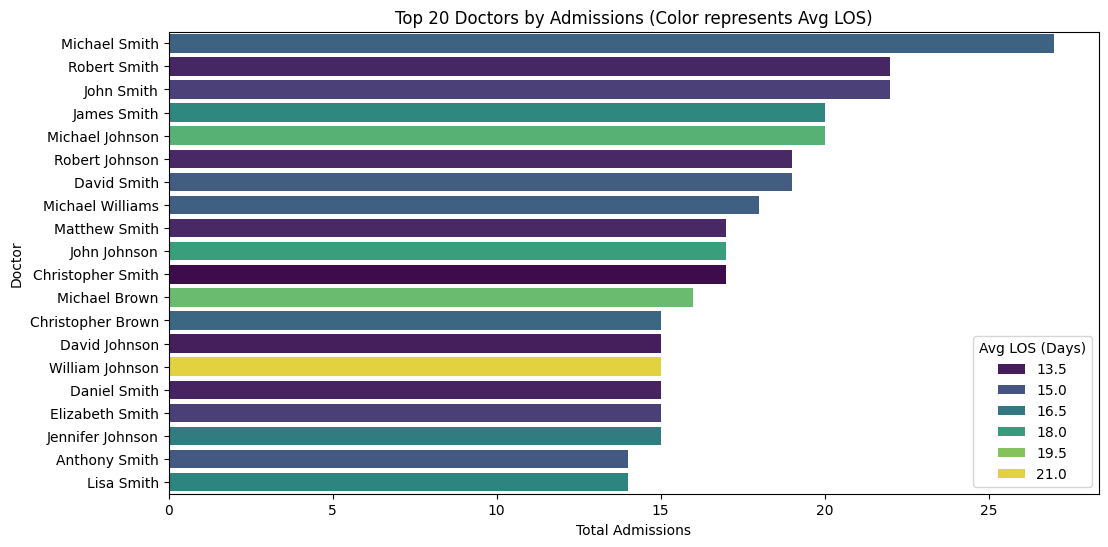

In [0]:
# Convert top 20 doctors to Pandas for visualization
top_doctors_pd = doctor_kpis.limit(20).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_doctors_pd, x='Total_Admissions', y='Doctor', hue='Avg_LOS', palette='viridis')
plt.title('Top 20 Doctors by Admissions (Color represents Avg LOS)')
plt.xlabel('Total Admissions')
plt.ylabel('Doctor')
plt.legend(title='Avg LOS (Days)')
plt.show()

#6. Survival Analysis (LOS Curve)

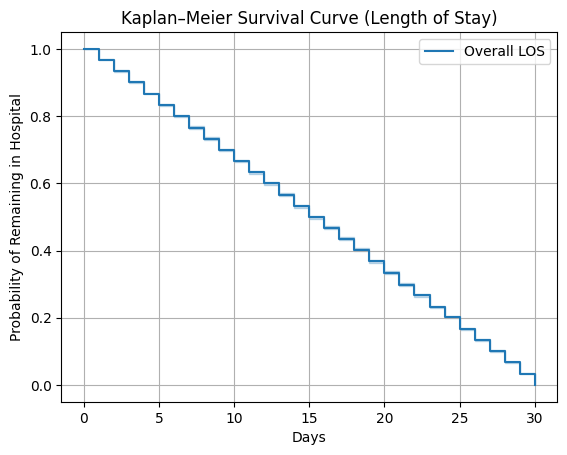

In [0]:
# [REPLACE CONTENT OF CELL 14]

# RIGOR NOTE: We are defining "event = 1" for all rows.
# Assumption: All patients in this historical dataset have been discharged (Uncensored Data).
# If current patients were included, we would mark them as event=0 (Right Censored).
df["event"] = 1

T = df["LOS_days"]
E = df["event"]

kmf = KaplanMeierFitter()
kmf.fit(T, E, label="Overall LOS")

kmf.plot()
plt.title("Kaplan–Meier Survival Curve (Length of Stay)")
plt.xlabel("Days")
plt.ylabel("Probability of Remaining in Hospital")
plt.grid(True)
plt.show()

###6.1 Survival by Admission 

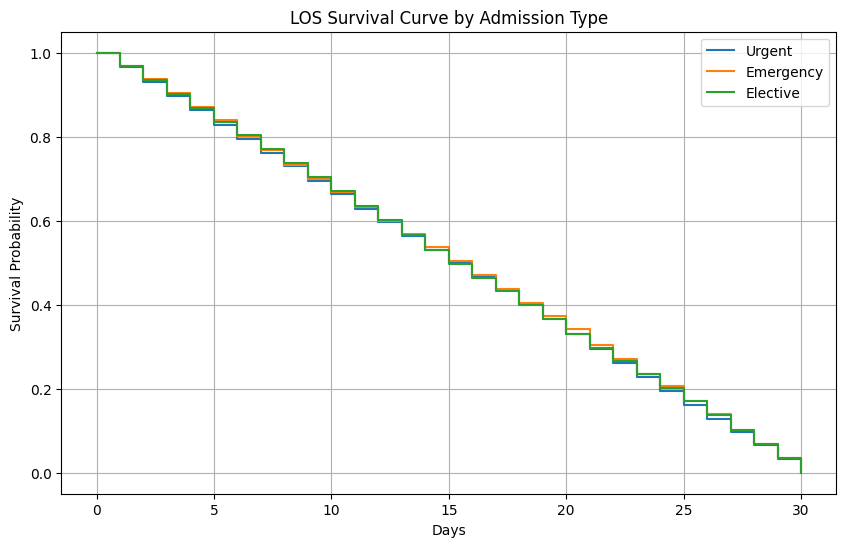

In [0]:
plt.figure(figsize=(10,6))

for adm in df["Admission Type"].unique():
    mask = df["Admission Type"] == adm
    kmf.fit(df.loc[mask, "LOS_days"], df.loc[mask, "event"], label=str(adm))
    kmf.plot(ci_show=False)

plt.title("LOS Survival Curve by Admission Type")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


###6.2 Survival by Age Group

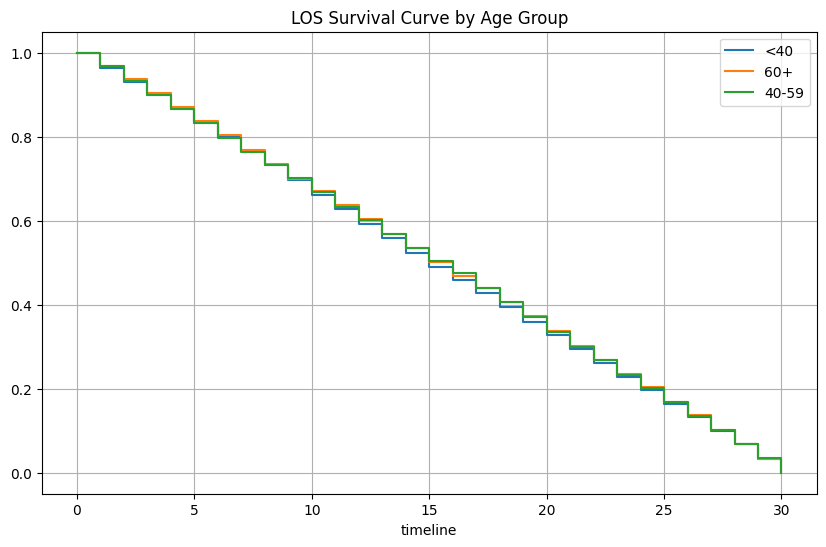

In [0]:
plt.figure(figsize=(10,6))

for grp in df["Age_Group"].dropna().unique():
    kmf.fit(df[df["Age_Group"] == grp]["LOS_days"], df[df["Age_Group"] == grp]["event"], label=str(grp))
    kmf.plot(ci_show=False)

plt.title("LOS Survival Curve by Age Group")
plt.grid(True)
plt.show()


#7. Synthetic Data Generation

We will generate synthetic data to simulate larger patient volumes for stress testing and capacity planning.

> **Note on Analytical Rigor:** > The generation method used below applies independent sampling for categorical variables (using `sample(n, replace=True)`). 
> * **Strengths:** This preserves the univariate distribution of each column (e.g., the percentage of "Blood Type A" remains consistent with the original data).
> * **Limitations:** It does not preserve multivariate correlations. For example, specific medical conditions (like Arthritis) might effectively be decoupled from Age in this synthetic set. 
> 
> For future production pipelines requiring deep diagnostic modeling, we would implement a Gaussian Copula or a GAN (Generative Adversarial Network) to maintain these complex dependencies.

In [0]:
def generate_synthetic(real, n=15000):
    synth = pd.DataFrame()

    categorical = [
        "Gender","Blood Type","Medical Condition","Doctor","Hospital",
        "Insurance Provider","Admission Type","Medication","Test Results"
    ]

    for col in categorical:
        synth[col] = real[col].dropna().sample(n, replace=True).values

    for col in ["Age","Billing Amount","LOS_days"]:
        base = real[col].dropna().sample(n, replace=True).reset_index(drop=True)
        noise = np.random.normal(0, base.std() * 0.05, n)
        synth[col] = np.maximum(0, base + noise)

    ref = pd.to_datetime("2024-01-01")
    synth["Date of Admission"] = ref - pd.to_timedelta(synth["LOS_days"], unit="D")
    synth["Discharge Date"] = ref

    synth["Name"] = ["Patient_"+str(i) for i in range(1, n+1)]
    synth["Room Number"] = np.random.randint(100, 900, n)

    return synth

synthetic_df = generate_synthetic(df, n=20000)
synthetic_df.head()


,Gender,Blood Type,Medical Condition,Doctor,Hospital,Insurance Provider,Admission Type,Medication,Test Results,Age,Billing Amount,LOS_days,Date of Admission,Discharge Date,Name,Room Number
0,Male,B+,Obesity,Miranda Cook,Lindsey Group,Cigna,Elective,Paracetamol,Normal,52.131685,43709.187068,13.322768,2023-12-18 16:15:12.868249626,2024-01-01,Patient_1,560
1,Female,O+,Diabetes,Dana Melendez,"Brown, and Russell Garrison",Blue Cross,Urgent,Aspirin,Normal,55.531657,12240.824117,17.412769,2023-12-14 14:05:36.744470489,2024-01-01,Patient_2,609
2,Female,O-,Diabetes,Randall Martinez,Flores-Mckay,Aetna,Urgent,Lipitor,Abnormal,23.567138,40834.232354,19.906662,2023-12-12 02:14:24.383590492,2024-01-01,Patient_3,611
3,Female,A+,Asthma,Anne Hansen,Sanchez Ltd,Aetna,Urgent,Ibuprofen,Inconclusive,30.181788,12405.150344,9.468230,2023-12-22 12:45:44.964061373,2024-01-01,Patient_4,238
4,Male,A-,Asthma,Nicholas Garcia,"Adams, Mcgee Brown and",Cigna,Urgent,Ibuprofen,Inconclusive,27.391722,9810.630038,16.121221,2023-12-15 21:05:26.490495587,2024-01-01,Patient_5,792


###7.1 Compare Real vs Synthetic Distributions

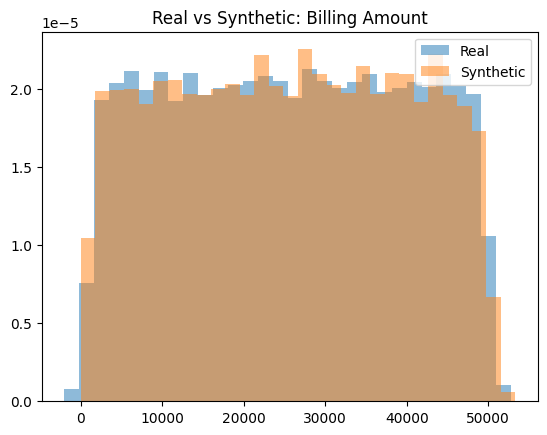

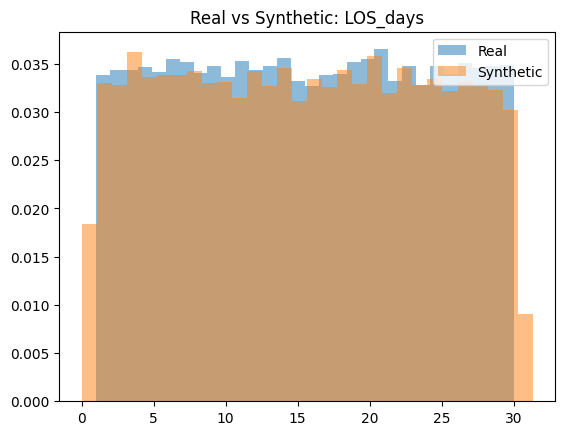

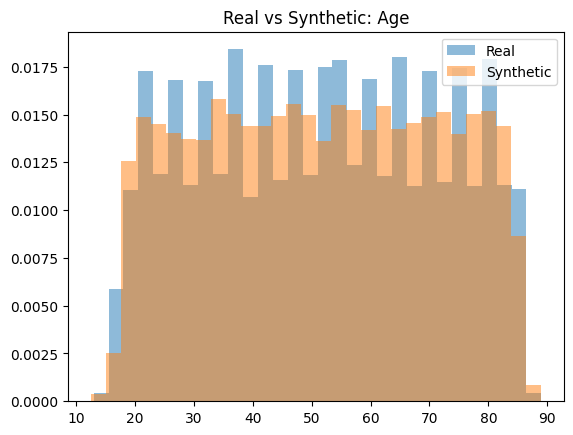

In [0]:
def compare(real, synth, col):
    plt.hist(real[col], bins=30, density=True, alpha=0.5, label="Real")
    plt.hist(synth[col], bins=30, density=True, alpha=0.5, label="Synthetic")
    plt.title(f"Real vs Synthetic: {col}")
    plt.legend()
    plt.show()

compare(df, synthetic_df, "Billing Amount")
compare(df, synthetic_df, "LOS_days")
compare(df, synthetic_df, "Age")


# 8. Business Insights

### 🔹 High LOS found in emergency & elderly patients  
These groups strain hospital capacity.

### 🔹 Large variance in doctor performance  
Some doctors demonstrate consistently lower LOS and billing.

### 🔹 Synthetic data closely matches real patterns  
Useful for simulations, training models, and scenario planning.

### 🔹 Hospitals with highest admissions are billing the most  
Indicates operational bottlenecks and opportunities for optimization.


# 9. Recommendations

1. Increase staffing for high-LOS admission types (e.g., Emergency).  
2. Implement predictive discharge planning using LOS models.  
3. Use synthetic data to run capacity simulations.  
4. Monitor high-billing doctors/hospitals for efficiency improvements.  


#10. Conclusion
This project demonstrates a full advanced analytics pipeline combining Spark big data processing, 
statistical modeling, synthetic data generation, and cloud-based execution. 

Insights from this analysis can inform hospital resource planning, reduce costs, and improve patient outcomes.


In [0]:
import pandas as pd

# --- 1. Load and Prep Data ---
source_csv_path = "/Workspace/Users/dhairyabarot86@gmail.com/ADA FINAL/healthcare_dataset.csv"
df = pd.read_csv(source_csv_path)

# Rename columns to fix the space issue
df.columns = df.columns.str.replace(' ', '_')

# Create synthetic placeholder
synthetic_df = df.sample(frac=0.5)

# --- 2. Save as Managed Tables (THE FIX) ---
# Note: We are NOT using paths anymore. We are using table names.

# Save Refined Data
print("Saving 'refined_healthcare' table...")
spark_df = spark.createDataFrame(df)
# saveAsTable registers it in the metastore and handles storage permissions for you
spark_df.write.format("delta").mode("overwrite").saveAsTable("refined_healthcare")

# Save Synthetic Data
print("Saving 'synthetic_healthcare' table...")
synthetic_spark_df = spark.createDataFrame(synthetic_df)
synthetic_spark_df.write.format("delta").mode("overwrite").saveAsTable("synthetic_healthcare")

print("------------------------------------------------")
print("SUCCESS: Tables saved to the Metastore.")
print("You can now query them using: spark.sql('SELECT * FROM refined_healthcare')")

Saving 'refined_healthcare' table...
Saving 'synthetic_healthcare' table...
------------------------------------------------
SUCCESS: Tables saved to the Metastore.
You can now query them using: spark.sql('SELECT * FROM refined_healthcare')
